# Non Stationary LSTM

주가처럼 그래프 자체만으로는 random walk수준의 그래프 이지만, 외부변수를 줌으로서 LSTM이 어떻게 예측을 할 수 있는지 테스트

In [1]:
%pylab inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Data

data x shape: (30000, 50, 6)
data y shape: (30000, 50, 2)


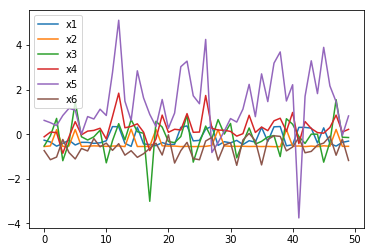

In [3]:
BATCH_SIZE=30000
TIME_SERIES_LENGTH = 50
OUTSIDE_VAR_COUNT = 6

# 요일 이펙트
def d1(x):
    return 1/(np.e * (x+0.023))

def d2(x):
    return -1/(x+0.02)

def d3(x):
    return 1/(x + 1.7)

def d4(x):
    return 2 + x/10

def d5(x):
    return  np.log(1/abs(x)) *  x

def create_data(batch_size=1000, time_series_length=500, moving_avg_n=1):
    funcs = [np.sin, np.cos, d1, d2, d3, d4, d5]
    func_count = len(funcs)
    
    x_data = np.zeros((batch_size, time_series_length, OUTSIDE_VAR_COUNT))
    y_data = np.zeros((batch_size, time_series_length, 2))

    for batch_idx in range(batch_size):
        ts_x = np.zeros((time_series_length, OUTSIDE_VAR_COUNT), dtype=np.float16)
        ts_y = np.zeros((time_series_length, 2))
        
        y1_prev, y2_prev, y3_prev, y4_prev, y5_prev, y6_prev = (0, 0, 0, 0, 0, 0)
        
        t = 0
        while t < time_series_length:
            x1 = np.random.rand(1)
            x2 = np.random.rand(1) * 0.1
            x3 = np.random.rand(1) * 0.5
            x4 = np.random.rand(1) * 1.2 + 0.5
            x5 = np.random.rand(1) * 1.5 + 2
            x6 = np.random.randn(1)
            
            if x1 > 0.8:
                x1 *= 2 + 0.5
                x2 *= 1.3 + 0.2
                x3 *= 0.5 + 1
                x4 *= 0.1 + 2
                x5 *= 1.5 + 1.2
            
            if x1 < 0.2:
                x2 += 2
                x3 += 3
                x4 = 1/x4
                x5 = 1/x5
                
            ts_x[t, 0] = x1
            ts_x[t, 1] = x2
            ts_x[t, 2] = funcs[t%func_count](x3) + x3 + y3_prev * 0.1
            ts_x[t, 3] = funcs[t%func_count](x4) + x4 + y4_prev * 0.2
            ts_x[t, 4] = funcs[t%func_count](x5) + x5 + y5_prev * 0.4
            ts_x[t, 5] = x6 + y6_prev * 0.1
            ts_y[t, 0] = funcs[t%func_count](x1) + x1 + y1_prev * 0.3
            ts_y[t, 1] = funcs[t%func_count](x2) + x2 + y2_prev * 0.5
            y1_prev, y2_prev, y3_prev, y4_prev, y5_prev, y6_prev = ts_x[t].tolist()
            
            if np.isinf(ts_x[t]).any() or np.isnan(ts_x[t]).any():
                print('haha', ts_x[t], y5_prev)
                continue
            t += 1
            
        x_data[batch_idx, :] = ts_x
        y_data[batch_idx, :] = ts_y
    return x_data, y_data
    
data_x, data_y = create_data(batch_size=BATCH_SIZE, 
                             time_series_length=TIME_SERIES_LENGTH)


# Scaling X
x_shape = data_x.shape
scaler_x = StandardScaler()
data_x = scaler_x.fit_transform(data_x.reshape(-1, 1))
data_x = data_x.reshape(x_shape)

plot(data_x[0, :, 0], label='x1')
plot(data_x[0, :, 1], label='x2')
plot(data_x[0, :, 2], label='x3')
plot(data_x[0, :, 3], label='x4')
plot(data_x[0, :, 4], label='x5')
plot(data_x[0, :, 5], label='x6')
legend()

# Scaling Y
y_shape = data_y.shape
scaler_y = StandardScaler()
data_y = scaler_y.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(y_shape)

# Split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=0)

print('data x shape:', data_x.shape)
print('data y shape:', data_y.shape)

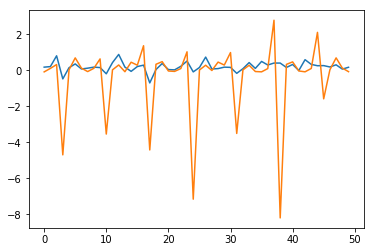

In [4]:
plot(data_y[0], label='y')

In [ ]:
np.savetxt('train_x.txt', train_x.reshape(-1, OUTSIDE_VAR_COUNT), delimiter=',')
np.savetxt('train_y.txt', train_y.reshape(-1, 2), delimiter=',')
np.savetxt('test_x.txt', test_x.reshape(-1, OUTSIDE_VAR_COUNT), delimiter=',')
np.savetxt('test_y.txt', test_y.reshape(-1, 2), delimiter=',')

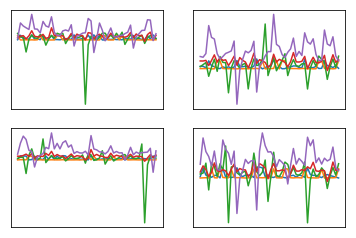

In [7]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
                        
            batch_idx = np.random.randint(data_x.shape[0])
            sample_x = data_x[batch_idx]
#             sample_y = data_y[batch_idx]
                                    
            sample_x1 = sample_x[:, 0]
            sample_x2 = sample_x[:, 1]
            sample_x3 = sample_x[:, 2]
            sample_x4 = sample_x[:, 3]
            sample_x5 = sample_x[:, 4]
        
            tick_x = range(sample_x.shape[0])
            
            sp.plot(tick_x, sample_x1, label='x1')
            sp.plot(tick_x, sample_x2, label='x2')
            sp.plot(tick_x, sample_x3, label='x3')
            sp.plot(tick_x, sample_x4, label='x4')
            sp.plot(tick_x, sample_x5, label='x5')
            
visualize(data_x, data_y)

## Model

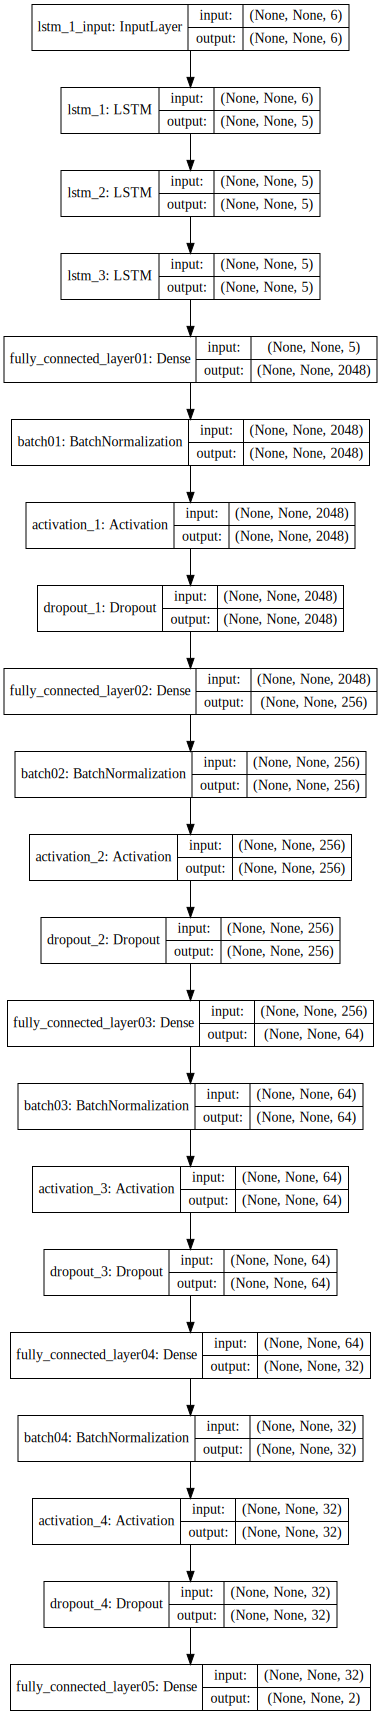

In [8]:
def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5, dense1=2048, dense2=256, dense3=64, dense4=32, 
                 optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(lstm_out1, batch_input_shape=(None, None, OUTSIDE_VAR_COUNT), return_sequences=True))
    if lstm_out2 is not None:
        model.add(LSTM(lstm_out2, return_sequences=True))
    
    if lstm_out3 is not None:
        model.add(LSTM(lstm_out3, return_sequences=True))
    
    model.add(Dense(dense1, name='fully_connected_layer01'))
    model.add(BatchNormalization(name='batch01'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(dense2, name='fully_connected_layer02'))
    model.add(BatchNormalization(name='batch02'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(dense3, name='fully_connected_layer03'))
    model.add(BatchNormalization(name='batch03'))
    model.add(Activation('relu'))
    model.add(Dropout(0.))
    
    model.add(Dense(dense4, name='fully_connected_layer04'))
    model.add(BatchNormalization(name='batch04'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(2, name='fully_connected_layer05'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training

In [10]:
model = create_model(lstm_out1=200, lstm_out2=170, lstm_out3=None, dense1=2560, dense2=1536, dense3=512, 
                     dense4=256)
model.fit(train_x, train_y, verbose=2, epochs=2500)

Epoch 1/2500
60s - loss: 0.3473 - mean_squared_error: 0.3473
Epoch 2/2500
59s - loss: 0.1043 - mean_squared_error: 0.1043
Epoch 3/2500
60s - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 4/2500
59s - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 5/2500
59s - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 6/2500
59s - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 7/2500
59s - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 8/2500
59s - loss: 0.0215 - mean_squared_error: 0.0215
Epoch 9/2500
59s - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 10/2500
59s - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 11/2500
59s - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 12/2500
59s - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 13/2500
59s - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 14/2500
59s - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 15/2500
59s - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 16/2500
59s - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 17/2500
59s

59s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 134/2500
59s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 135/2500
59s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 136/2500
59s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 137/2500
59s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 138/2500
59s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 139/2500
59s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 140/2500
59s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 141/2500
59s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 142/2500
59s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 143/2500
59s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 144/2500
59s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 145/2500
59s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 146/2500
59s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 147/2500
59s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 148/2500
59s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 1

59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 265/2500
59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 266/2500
59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 267/2500
59s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 268/2500
59s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 269/2500
59s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 270/2500
59s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 271/2500
59s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 272/2500
59s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 273/2500
59s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 274/2500
59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 275/2500
59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 276/2500
59s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 277/2500
59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 278/2500
59s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 279/2500
59s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 2

59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 396/2500
59s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 397/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 398/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 399/2500
59s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 400/2500
59s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 401/2500
59s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 402/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 403/2500
59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 404/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 405/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 406/2500
59s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 407/2500
59s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 408/2500
59s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 409/2500
59s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 410/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4

59s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 527/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 528/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 529/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 530/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 531/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 532/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 533/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 534/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 535/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 536/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 537/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 538/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 539/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 540/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 541/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 5

59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 658/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 659/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 660/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 661/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 662/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 663/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 664/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 665/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 666/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 667/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 668/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 669/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 670/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 671/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 672/2500
59s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 6

59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 789/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 790/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 791/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 792/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 793/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 794/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 795/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 796/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 797/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 798/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 799/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 800/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 801/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 802/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 803/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 8

59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 920/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 921/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 922/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 923/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 924/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 925/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 926/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 927/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 928/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 929/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 930/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 931/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 932/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 933/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 934/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9

59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1050/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1051/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1052/2500
59s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1053/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1054/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1055/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1056/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1057/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1058/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1059/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1060/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1061/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1062/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1063/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1064/2500
59s - loss: 0.0034 - mean_squared_error:

59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1179/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1180/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1181/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1182/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1183/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1184/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1185/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1186/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1187/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1188/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1189/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1190/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1191/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1192/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1193/2500
59s - loss: 0.0034 - mean_squared_error:

59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1308/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1309/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1310/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1311/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1312/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1313/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1314/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1315/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1316/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1317/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1318/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1319/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1320/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1321/2500
59s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1322/2500
59s - loss: 0.0034 - mean_squared_error:

59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1437/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1438/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1439/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1440/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1441/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1442/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1443/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1444/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1445/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1446/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1447/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1448/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1449/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1450/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1451/2500
59s - loss: 0.0033 - mean_squared_error:

59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1566/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1567/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1568/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1569/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1570/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1571/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1572/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1573/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1574/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1575/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1576/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1577/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1578/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1579/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1580/2500
59s - loss: 0.0034 - mean_squared_error:

59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1695/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1696/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1697/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1698/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1699/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1700/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1701/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1702/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1703/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1704/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1705/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1706/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1707/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1708/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1709/2500
59s - loss: 0.0033 - mean_squared_error:

59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1824/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1825/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1826/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1827/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1828/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1829/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1830/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1831/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1832/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1833/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1834/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1835/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1836/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1837/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1838/2500
59s - loss: 0.0033 - mean_squared_error:

59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 1953/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1954/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1955/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1956/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1957/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1958/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1959/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1960/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1961/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1962/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1963/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1964/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1965/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1966/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1967/2500
59s - loss: 0.0033 - mean_squared_error:

59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2082/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2083/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2084/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2085/2500
59s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2086/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2087/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2088/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2089/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2090/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2091/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2092/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2093/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2094/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2095/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2096/2500
59s - loss: 0.0032 - mean_squared_error:

59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2211/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2212/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2213/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2214/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2215/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2216/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2217/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2218/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2219/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2220/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2221/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2222/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2223/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2224/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2225/2500
59s - loss: 0.0032 - mean_squared_error:

59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2340/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2341/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2342/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2343/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2344/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2345/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2346/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2347/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2348/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2349/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2350/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2351/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2352/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2353/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2354/2500
59s - loss: 0.0032 - mean_squared_error:

59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2469/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2470/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2471/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2472/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2473/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2474/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2475/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2476/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2477/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2478/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2479/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2480/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2481/2500
59s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 2482/2500
59s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 2483/2500
59s - loss: 0.0032 - mean_squared_error:

error:0.0008827038115598655, score:0.9991092366132933
score: 0.999109236613


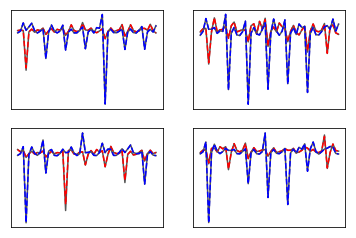

In [21]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 2))
    y_pred = y_pred.reshape((-1, 2))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


def visualize_prediction(data_x, data_y):
    pred_y = model.predict(data_x)
    
    print('score:', accuracy(data_y, pred_y))
    
    fig, sub_plots = subplots(2, 2)
    
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            sp.plot(data_y[idx, :, 0], color='#555555')
            sp.plot(pred_y[idx, :, 0], color='red', linestyle='--')
            
            sp.plot(data_y[idx, :, 1], color='#555555')
            sp.plot(pred_y[idx, :, 1], color='blue', linestyle='--')

visualize_prediction(test_x, test_y)

In [15]:
test_x.shape, test_y.shape

((6000, 50, 6), (6000, 50, 2))

In [12]:
model.save('model06.h5')

# Test

### test1

```
model = create_model(lstm_out1=200, lstm_out2=170, lstm_out3=None, dense1=2560, dense2=1536, 
                     dense3=512,dense4=256)
model.fit(train_x, train_y, verbose=2, epochs=2000)

error:0.0008827038115598655, score:0.9991092366132933
score: 0.999109236613
```